[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SilverViking/deep-learning-biology/blob/main/exercises/assignments/2020-dlb-4-rnn.ipynb)

# Exercise 4: Recurrent Neural Networks

In this notebook, we will be using recurrent neural networks (RNN) to predict secondary structure (SS) from protein sequences. 

The structure of these exercises is as follows: 

1. [Import libraries and download data](#scrollTo=ScagUEMTMjlK)
2. [Data pre-processing](#scrollTo=9ZKz5lBePiZn)
3. [RNN for SS prediction](#scrollTo=TreeLUegygQt)
4. [LSTM for SS prediction](#scrollTo=dYrVpP0s0Zm4)
5. [Extension with convolutional layers](#scrollTo=PHqTVcZrAPhH)

This notebook is largely based on the research published in: 

Torrisi, M., Kaleel, M., & Pollastri, G. (2019). Deeper Profiles and Cascaded Recurrent and Convolutional Neural Networks for state-of-the-art Protein Secondary Structure Prediction. Scientific Reports. https://doi.org/10.1038/s41598-019-48786-x

## 1. Import libraries and download data
Let's start with importing the necessary libraries. 

In [2]:
import os
import numpy as np
import gdown
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
plt.rcdefaults()
from sklearn import metrics
from progressbar import ProgressBar, Percentage, Bar, ETA, FileTransferSpeed

As you will notice, Colab environments come with quite a large library pre-installed. If you need to import a module that is not yet specified, you can add it in the previous cell (make sure to run it again). If the module is not installed, you can install it with `pip`. 

To make your work reproducible, it is advised to initialize all modules with stochastic functionality with a fixed seed. Re-running this script should give the same results as long as the seed is fixed. 

In [3]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


We will now download the required data from a public Google Drive repository. The data is stored as a zip archive and automatically extracted to the `data` directory in the current directory. 

In [4]:
# fields
url = 'http://data.bits.vib.be/pub/trainingen/DeepLearning/data-4.zip'
cmp_data_path = 'data.zip'

# download the compressed data
gdown.download(url, cmp_data_path, quiet=False)

# extract the data
zip = zipfile.ZipFile(cmp_data_path)
zip.extractall('')

# remove the compressed data
os.remove(cmp_data_path)

Downloading...
From: http://data.bits.vib.be/pub/trainingen/DeepLearning/data-4.zip
To: /content/data.zip
100%|██████████| 526M/526M [00:15<00:00, 34.0MB/s]


## 2. Data visualization and pre-processing

The data used for this exercise session originates from the Protein Data Bank (PDB), a public repository of all freely and publicly known protein structures. Eight classes of secondary structure were annotated: helices (G, H, I), sheets (E, B) and coils (C, S, T). 

Let's start by extracting and loading the data. This notebook can be relatively RAM intensive. By default, you will only use 30% of the available data. If you notice crashes due to RAM overuse, please reduce the `frac` parameter below. You will use less data, and therefore less RAM, so the results will be slightly worse, but your conclusions should not be affected. 

In [5]:
# function that loads and preprocesses the dataset
def load_dataset(f, frac=0.5):

    file = open(f, 'r') 

    # read in header
    n_proteins = int(file.readline())
    input_per_AA_classess = file.readline()
    data = file.readlines()

    # select a fraction of the data (due to RAM limitations, should be a multiple of 5)
    max_lines = (int(len(data) * frac) // 5) * 5
    data = data[:max_lines]

    # read in the actual data
    pdb_ids = []
    lengths = []
    encoded_inputs = []
    secondary_structures = []
    widgets = ['Loading data: ', Percentage(), ' ', Bar(), ' ', ETA()]
    pbar = ProgressBar(widgets=widgets, maxval=len(data))
    pbar.start()
    for i, line in enumerate(data):
        line = line.replace('\n', '')
        if i % 5 == 0:
            pdb_ids.append(line)
        elif i % 5 == 1:
            length = int(line)
            lengths.append(length)
        elif i % 5 == 2:
            encoded_input = np.asarray(line.split(' '), dtype=float).reshape((length, 22))
            encoded_inputs.append(encoded_input) 
        elif i % 5 == 3:
            secondary_structure = np.asarray(line[:-1].split(' '), dtype=int)
            secondary_structures.append(secondary_structure)
        pbar.update(i)
    pbar.finish()

    # save the lengths as a numpy array
    lengths = np.asarray(lengths, dtype=int)

    # pad all sequences to the length of the longest sequence (with zeros)
    # the corresponding secondary labels are padded with negative values
    max_length = lengths.max()
    widgets = ['Padding data: ', Percentage(), ' ', Bar(), ' ', ETA()]
    pbar = ProgressBar(widgets=widgets, maxval=len(encoded_inputs))
    pbar.start()
    for i, ei in enumerate(encoded_inputs):
        encoded_inputs[i] = np.pad(ei, ((0, max_length - ei.shape[0]), (0, 0)), 'constant', constant_values=0)
        secondary_structures[i] = np.pad(secondary_structures[i], ((0, max_length - secondary_structures[i].shape[0])), 
                                        'constant', constant_values=-1)
        pbar.update(i)
    pbar.finish()

    # save the data in numpy arrays
    encoded_inputs = np.asarray(encoded_inputs)
    secondary_structures = np.asarray(secondary_structures, dtype=int)

    return pdb_ids, encoded_inputs, secondary_structures, lengths

# path to the data
f_train = 'data-4/train-vHHblits.dataset'
f_test = 'data-4/test-vHHblits.dataset'

# load only a fraction due to RAM limitations
frac = 0.3

# load the data
pdb_ids_train, encoded_inputs_train, secondary_structures_train, lengths_train = load_dataset(f_train, frac=frac)
pdb_ids_test, encoded_inputs_test, secondary_structures_test, lengths_test = load_dataset(f_test, frac=frac)

# mappings of the class indices to secondary structure labels
mappings = ['G', 'H', 'I', 'E', 'B', 'C', 'S', 'T']

# print out basic statistics
print()
print('There are %d protein sequences in the training set, with an average length of %.2f. The class distribution is as follows: ' % (encoded_inputs_train.shape[0], lengths_train.mean()))
for i, label in enumerate(mappings):
    print('%s: %.2f%%' % (label, (secondary_structures_train == i).sum() / (secondary_structures_train >= 0).sum() * 100))
print('There are %d protein sequences in the testing set, with an average length of %.2f. The class distribution is as follows: ' % (encoded_inputs_test.shape[0], lengths_test.mean()))
for i, label in enumerate(mappings):
    print('%s: %.2f%%' % (label, (secondary_structures_test == i).sum() / (secondary_structures_test >= 0).sum() * 100))

Loading data: 100% |###########################################| Time:  0:00:05
Padding data: 100% |###########################################| Time:  0:00:01
Loading data: 100% |###########################################| Time:  0:00:00
Padding data: 100% |###########################################| Time:  0:00:00



There are 4725 protein sequences in the training set, with an average length of 241.58. The class distribution is as follows: 
G: 3.71%
H: 34.25%
I: 0.02%
E: 21.42%
B: 1.08%
C: 19.93%
S: 8.53%
T: 11.07%
There are 946 protein sequences in the testing set, with an average length of 229.04. The class distribution is as follows: 
G: 3.90%
H: 31.40%
I: 0.01%
E: 23.32%
B: 1.24%
C: 20.09%
S: 8.46%
T: 11.57%


3154

22 8

3X2MA

180

1.0 0.0 0.0 0.0 0.0 0.0275888349786 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.119453898303 0.0 0.0 0.0 0.0 0.0 0.0 0.0280826356455 0.0 0.0185311810736 0.0 0.016030819467 0.00740105863926 0.0141890655527 0.0 0.0 0.0292717752932 0.0 0.0 0.102992254589 0.00956750865276 0.0266044688366 0.177136175668 1.0 0.0363685796912 0.0 0.0 0.0 0.0 0.179064621968 0.0 0.0122717556165 0.0 0.0 1.0 0.0 0.0108037669596 0.0 0.0 0.0 0.05150944902 0.0 0.0 0.0 0.0234242172677 0.0802203573701 0.0 0.0 0.0 0.0 0.0 0.161132895484 0.0 0.0 0.0108632155325 0.00613399066942 1.0 0.0 0.0 0.0137635232359 ...

5 0 0 0 5 5 5 5 6 3 3 3 3 3 3 3 3 3 6 5 5 6 6 5 7 7 6 5 5 4 6 6 5 3 3 3 3 3 1 1 1 1 7 6 5 7 7 6 5 5 5 7 7 7 7 5 3 3 3 3 3 3 3 3 5 7 7 5 7 7 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 5 6 7 7 5 7 7 7 6 5 5 5 6 6 6 5 6 5 7 7 6 5 6 3 3 3 3 3 3 7 7 7 7 1 1 1 1 1 6 5 7 7 5 5 5 3 3 3 3 3 3 3 3 5 0 0 0 5 5 5 5 4 5 5 5 5 6 7 7 5 5 5 0 0 0 0 6 5 6 6 6 5 5 6 6 5 5 5 6 5 5 5 5 
 
5AL6A
44
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.195550902832 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.274816298067 ...

5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 
 

In [6]:
print(pdb_ids_train[:1])
print(encoded_inputs_train[:1].shape)
print(secondary_structures_train[:1].shape)
print(secondary_structures_train[:1])
print(lengths_train[:1])

print(encoded_inputs_test[:1].shape)

['1EJGA']
(1, 3005, 22)
(1, 3005)
[[ 5  3  3 ... -1 -1 -1]]
[46]
(1, 1455, 22)


Even though the data is quite imbalanced, it turns out we can predict one of these eight classes relatively accurate (see the paper reference at the start of this notebook). In this tutorial, however, we will simplify the problem a little bit by merging the secondary structures up to the level of helices, sheets and coils. The following block of code performs this merging step and prints out the class distribution. 

In [7]:
# group labels to helices, sheets and coils for simplicity
secondary_structures_group_train = np.copy(secondary_structures_train)
helices = (secondary_structures_train == 0) + (secondary_structures_train == 1) + (secondary_structures_train == 2)
secondary_structures_group_train[helices] = 0
sheets = (secondary_structures_train == 3) + (secondary_structures_train == 4)
secondary_structures_group_train[sheets] = 1
coils = (secondary_structures_train == 5) + (secondary_structures_train == 6) + (secondary_structures_train == 7)
secondary_structures_group_train[coils] = 2

# same for test set
secondary_structures_group_test = np.copy(secondary_structures_test)
helices = (secondary_structures_test == 0) + (secondary_structures_test == 1) + (secondary_structures_test == 2)
secondary_structures_group_test[helices] = 0
sheets = (secondary_structures_test == 3) + (secondary_structures_test == 4)
secondary_structures_group_test[sheets] = 1
coils = (secondary_structures_test == 5) + (secondary_structures_test == 6) + (secondary_structures_test == 7)
secondary_structures_group_test[coils] = 2

# print out statistics of the grouped labels
mappings_hl = ['helices', 'sheets', 'coils']
print()
print('The grouped class distribution in the training set is as follows: ')
for i, label in enumerate(mappings_hl):
    print('%s: %.2f%%' % (label, (secondary_structures_group_train == i).sum() / (secondary_structures_group_train >= 0).sum() * 100))
print('The grouped class distribution in the training set is as follows: ')
for i, label in enumerate(mappings_hl):
    print('%s: %.2f%%' % (label, (secondary_structures_group_test == i).sum() / (secondary_structures_group_test >= 0).sum() * 100))


The grouped class distribution in the training set is as follows: 
helices: 37.98%
sheets: 22.50%
coils: 39.52%
The grouped class distribution in the training set is as follows: 
helices: 35.31%
sheets: 24.57%
coils: 40.12%


It seems that the sheets class is slightly under-represented. We will correct this by using the following class weights: 
$$w_c = \frac{N}{C \times N_c}$$
where $N=4725$ is the total amount of training samples, $C=3$ the amount of classes and $N_c$ is the amount of samples that belong to class $c$. 

In [8]:
# computing balancing weights
t = (secondary_structures_group_train >= 0).sum()
w = [t / (3 * (secondary_structures_group_train == i).sum()) for i in range(3)]
w = np.asarray(w)
print()
print('Class balancing weights: ')
for i, label in enumerate(mappings_hl):
    print('%s: %.2f' % (label, w[i]))


Class balancing weights: 
helices: 0.88
sheets: 1.48
coils: 0.84


As you can see, the sheets class will be assigned a larger weight to cope with its slight under-representation. 

Now that we have our data in order, it is time to define a dataloader that can be used for our predictive recurrent networks. The dataloader should return sequences of encodings and their corresponding labels. 

In [9]:
batch_size = 247

train = TensorDataset(torch.from_numpy(encoded_inputs_train).float(), 
                      torch.from_numpy(secondary_structures_group_train))
test = TensorDataset(torch.from_numpy(encoded_inputs_test).float(), 
                     torch.from_numpy(secondary_structures_group_test))

dataloader_train = DataLoader(train, batch_size=batch_size)
dataloader_test = DataLoader(test, batch_size=batch_size)

In [10]:
x, y = train[2]
print(x)
print(y)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3480,  ..., 0.0000, 0.0000, 0.0000],
        [0.0667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([ 2,  0,  0,  ..., -1, -1, -1])


Sequence 2:
    - input shape = [101, 22]
    - output shape = [101]
    - length = 101
    - AA-encoding length = 22
    - padded length = 3005


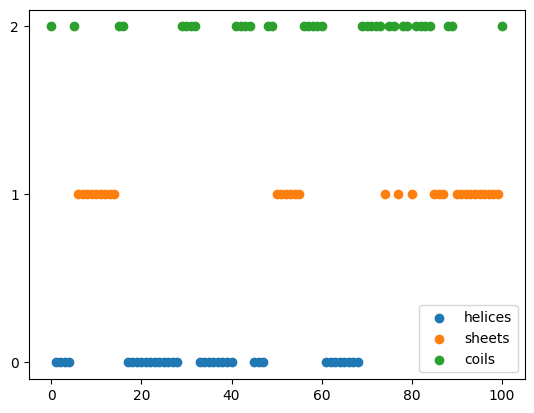

In [11]:
i = 2
x, y = train[i]
x = x[:lengths_train[i]]
y = y[:lengths_train[i]]
print('Sequence %d:' % i)
print('    - input shape = %s' % str(list(x.shape)))
print('    - output shape = %s' % str(list(y.shape)))
print('    - length = %d' % x.shape[0])
print('    - AA-encoding length = %d' % x.shape[1])
print('    - padded length = %d' % train[i][0].shape[0])
for i in range(3):
    plt.scatter(np.arange(len(y))[y==i], y[y==i])
plt.legend(mappings_hl)
plt.yticks(np.arange(3))
plt.show()

This plot shows the dimensions of a particular input sequence. Each amino-acid (AA) is encoded as a vector of length $A=22$. Each AA has a corresponding secondary structure (helix, sheet or coil). The protein sequences are variable length, however, we have padded the sequences to match with the longest sequence. The corresponding secondary structure labels for these paddings were set to -1. 

## 3. RNN for SS prediction

Now we are ready to define a recurrent network that can process the protein sequences and predict the corresponding SS label. The model will consist of an RNN that takes an input sequence and maps this to a hidden state. This hidden state can then be fed to a linear layer to predict the SS of the protein sequence. You can chose the dimensionality of the hidden state yourself. 

**Exercise**: implement the `RNNNet` class, more specifically: 
- Implement the initializer by defining the correct layers: you will need an [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) layer and a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer that performs classification. 
- Implement the forward propagation function. 
- Evaluate the performance by plotting the learning curves and showing the confusion matrix

Note: the nn.RNN module implements the network shown below. In our case each x_i is a vector of 22 element (encoding the amino acide), and we will present the full input vector x as a tensor (batch size, padded sequence length, 22). The hidden state is e.g. 15-dimensional. So the input to nn.RNN are the blue circles, the output the hidden states h_i (as well as h_t which we don't care about).

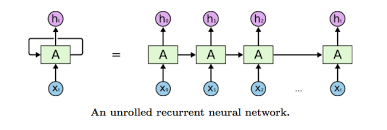

In [15]:
class RNNNet(nn.Module):
    
    def __init__(self):
        super(RNNNet, self).__init__()

        """
        INSERT CODE HERE
        """
        input_size = 22  # each amino acid is encoded as a 22-dimensional vector (20 amino acids + gap + unknown; encoding is *not* one-hot but includes evolutionary information from multiple sequence alignment of the protein)
        hidden_size = 15  # for example
        output_size = 3  # three possible secondary structures: helix, sheet, coil
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        """
        INSERT CODE HERE
        """
        h_ts, h_n = self.rnn(x, None)  # None indicates we do no want to specify an initial internal state

        # The tensor with hidden states after processing each amino acid is now
        # passed to the Linear module for classification. The tensor has 15 values (hidden_size) per amino acid in the sequence. (+batch dimension)
        x = self.classifier(h_ts)

        return x


rnn = RNNNet().to(device)
print(rnn)

RNNNet(
  (rnn): RNN(22, 15, batch_first=True)
  (classifier): Linear(in_features=15, out_features=3, bias=True)
)


You can use the code below to train and evaluate your implemented model. For a given input sequence, your model should return a sequence of class probability distributions. More precisely, for a batch size $B$ and sequence of length $S$, the input has shape $[B, S, A]$ and the output has shape $[B, S, C]$. 

In [16]:
# evaluates the performance of a model and return the predictions and ground truth
def evaluate(model, loader):
    model.eval()
    outputs = []
    predictions = []
    for i, batch in enumerate(loader):
        sequences = batch[0].to(device)
        output = batch[1].to(device)
        prediction = model(sequences)
        
        output = output.flatten()
        mask = output >= 0
        output = output[mask]
        prediction = prediction.argmax(dim=2).flatten()
        prediction = prediction[mask]
        
        predictions.append(prediction.detach().cpu().numpy())
        outputs.append(output.detach().cpu().numpy())
    
    return np.hstack(predictions), np.hstack(outputs)

# implementation of a single training epoch
def train_epoch(net, loader, loss_fn, optimizer):
    
    # set the network in training mode
    net.train()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)
        
        # set all gradients equal to zero
        net.zero_grad()
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred.view(-1, y_pred.size(2)), y.flatten())
        loss_cum += loss.data.cpu().numpy()
        cnt += 1
        
        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg

# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):
    
    # set the network in evaluation mode
    net.eval()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred.view(-1, y_pred.size(2)), y.flatten())
        loss_cum += loss.data.cpu().numpy()
        cnt += 1
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg

def train_net(net, train_loader, test_loader, loss_fn, optimizer, epochs):
    
    # transfer the network to the GPU
    net = net.to(device)
    
    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    test_acc = np.zeros((epochs))
    for epoch in range(epochs):
        
        # training
        train_loss[epoch] = train_epoch(net, train_loader, loss_fn, optimizer)
        predictions, outputs = evaluate(net, train_loader)
        train_acc[epoch] = metrics.balanced_accuracy_score(outputs, predictions)
        
        # testing
        test_loss[epoch] = test_epoch(net, test_loader, loss_fn)
        predictions, outputs = evaluate(net, test_loader)
        test_acc[epoch] = metrics.balanced_accuracy_score(outputs, predictions)
        
        print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f' 
              % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))
    
    return (train_loss, test_loss), (train_acc, test_acc)

epochs = 10
lr = 1e-2

loss_fn = nn.CrossEntropyLoss(ignore_index=-1, weight=torch.from_numpy(w).to(device).float())
optimizer = optim.Adam(rnn.parameters(), lr=lr)

loss_rnn, acc_rnn = train_net(rnn, dataloader_train, dataloader_test, loss_fn, optimizer, epochs)

Epoch     0 - Train loss: 1.036070 - Train accuracy: 0.537478 - Test loss: 0.961252 - Test accuracy: 0.533556
Epoch     1 - Train loss: 0.923930 - Train accuracy: 0.584296 - Test loss: 0.909601 - Test accuracy: 0.581121
Epoch     2 - Train loss: 0.897355 - Train accuracy: 0.595273 - Test loss: 0.891748 - Test accuracy: 0.591876
Epoch     3 - Train loss: 0.891568 - Train accuracy: 0.597768 - Test loss: 0.892359 - Test accuracy: 0.592961
Epoch     4 - Train loss: 0.886101 - Train accuracy: 0.599788 - Test loss: 0.890278 - Test accuracy: 0.594041
Epoch     5 - Train loss: 0.881370 - Train accuracy: 0.602042 - Test loss: 0.887560 - Test accuracy: 0.595957
Epoch     6 - Train loss: 0.877606 - Train accuracy: 0.603686 - Test loss: 0.883943 - Test accuracy: 0.597447
Epoch     7 - Train loss: 0.874865 - Train accuracy: 0.605038 - Test loss: 0.881180 - Test accuracy: 0.598163
Epoch     8 - Train loss: 0.873029 - Train accuracy: 0.606421 - Test loss: 0.878710 - Test accuracy: 0.599517
Epoch     

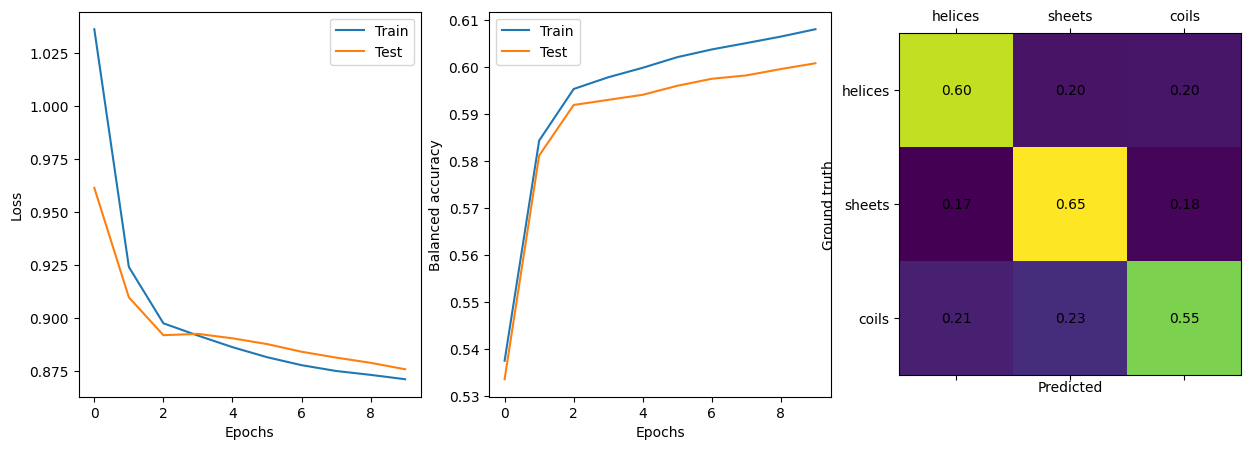

In [17]:
plt.rcParams["figure.figsize"] = (15,5)

# plot train/test loss curves
"""
INSERT CODE HERE
"""
plt.subplot(1, 3, 1)
plt.plot(loss_rnn[0])
plt.plot(loss_rnn[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(('Train', 'Test'))


# plot train/test balanced accuracy
"""
INSERT CODE HERE
"""
plt.subplot(1, 3, 2)
plt.plot(acc_rnn[0])
plt.plot(acc_rnn[1])
plt.xlabel('Epochs')
plt.ylabel('Balanced accuracy')
plt.legend(('Train', 'Test'))


# show the confusion matrix
"""
INSERT CODE HERE
"""
predictions, outputs = evaluate(rnn, dataloader_test)
cm = metrics.confusion_matrix(outputs, predictions, normalize='true')
ax = plt.subplot(1, 3, 3)
ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '%.2f' % z, ha='center', va='center')
ax.set_xticklabels([''] + mappings_hl)
ax.set_yticklabels([''] + mappings_hl)
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.show()


That seems not too bad. You should be able to achieve a test balanced accuracy of about 60%. The training curve also indicates that we might be able to get higher test accuracy by training it a little longer. 

## 3. LSTM for SS prediction

Now that we have a working RNN, we can try and improve it by changing it into an LSTM. 

**Exercise**: implement the `LSTMNet` class, more specifically: 
- Implement the initializer by defining the correct layers: you will need an [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer and a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer that performs classification. 
- Implement the forward propagation function. 
- Make the LSTM bidirectional and evaluate the performance
- Change the hidden size and evaluate the performance
- Change the number of layers in the LSTM, i.e. the amount of LSTMs stacked on top of each other and evaluate the performance. 

In [23]:
class LSTMNet(nn.Module):
    
    def __init__(self, hidden_size=16, bidirectional=False, num_layers=1):
        super(LSTMNet, self).__init__()

        """
        INSERT CODE HERE
        """
        n = 2 if bidirectional else 1

        num_output_features = 3
        input_size = 22

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n, bidirectional=bidirectional, batch_first=True)
        self.classifier = nn.Linear(n * hidden_size, num_output_features)

    def forward(self, x):

        """
        INSERT CODE HERE
        """
        x, h = self.lstm(x, None)
        x = self.classifier(x)
        return x


"""
INSERT CODE HERE
"""
lstms = [LSTMNet().to(device),
         LSTMNet(bidirectional=True).to(device),
         LSTMNet(hidden_size=32).to(device),
         LSTMNet(num_layers=2).to(device),
         LSTMNet(bidirectional=True, hidden_size=32, num_layers=2).to(device)]

loss_lstms = []
acc_lstms = []
for lstm in lstms:
  optimizer = optim.Adam(lstm.parameters(), lr=lr) # we need a new optimizer, associated with our new lstm
  loss_lstm, acc_lstm = train_net(lstm, dataloader_train, dataloader_test, loss_fn, optimizer, epochs)
  loss_lstms.append(loss_lstm)
  acc_lstms.append(acc_lstm)

Epoch     0 - Train loss: 1.050154 - Train accuracy: 0.555961 - Test loss: 0.988730 - Test accuracy: 0.553507
Epoch     1 - Train loss: 0.942431 - Train accuracy: 0.584775 - Test loss: 0.907386 - Test accuracy: 0.578394
Epoch     2 - Train loss: 0.885150 - Train accuracy: 0.602844 - Test loss: 0.878089 - Test accuracy: 0.595734
Epoch     3 - Train loss: 0.872322 - Train accuracy: 0.606525 - Test loss: 0.869224 - Test accuracy: 0.601138
Epoch     4 - Train loss: 0.861832 - Train accuracy: 0.612610 - Test loss: 0.862819 - Test accuracy: 0.606513
Epoch     5 - Train loss: 0.854461 - Train accuracy: 0.616325 - Test loss: 0.855707 - Test accuracy: 0.609293
Epoch     6 - Train loss: 0.848380 - Train accuracy: 0.620855 - Test loss: 0.849629 - Test accuracy: 0.613092
Epoch     7 - Train loss: 0.841023 - Train accuracy: 0.625709 - Test loss: 0.842751 - Test accuracy: 0.617675
Epoch     8 - Train loss: 0.832207 - Train accuracy: 0.631509 - Test loss: 0.833507 - Test accuracy: 0.622298
Epoch     

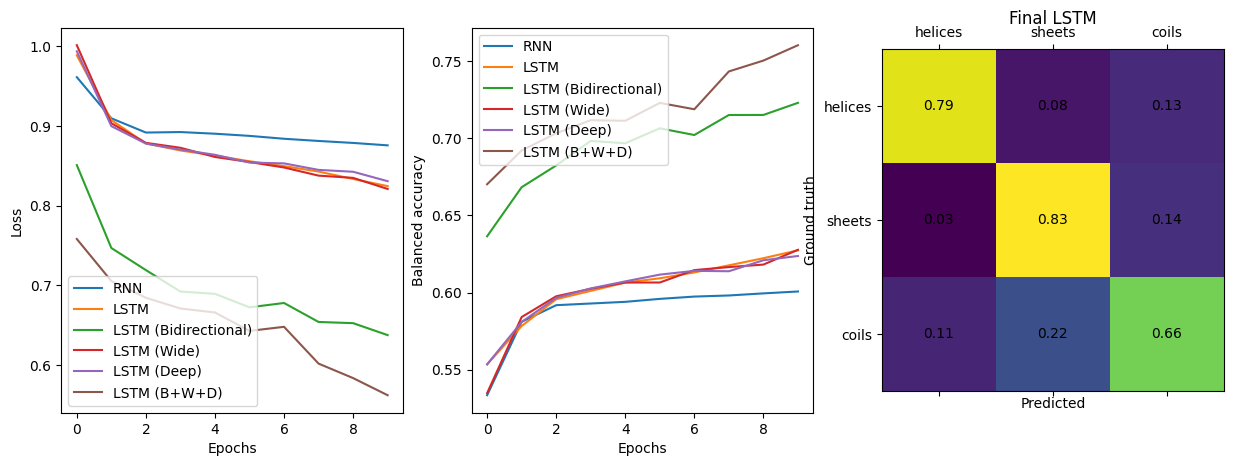

In [24]:
plt.rcParams["figure.figsize"] = (15,5)

# plot test loss curves
"""
INSERT CODE HERE
"""
plt.subplot(1, 3, 1)
plt.plot(loss_rnn[1])
for loss_lstm in loss_lstms:
    plt.plot(loss_lstm[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(('RNN', 'LSTM', 'LSTM (Bidirectional)', 'LSTM (Wide)', 'LSTM (Deep)', 'LSTM (B+W+D)'))

# plot test balanced accuracy
"""
INSERT CODE HERE
"""
plt.subplot(1, 3, 2)
plt.plot(acc_rnn[1])
for acc_lstm in acc_lstms:
    plt.plot(acc_lstm[1])
plt.xlabel('Epochs')
plt.ylabel('Balanced accuracy')
plt.legend(('RNN', 'LSTM', 'LSTM (Bidirectional)', 'LSTM (Wide)', 'LSTM (Deep)', 'LSTM (B+W+D)'))

# show the confusion matrix of the best performing model
"""
INSERT CODE HERE
"""
predictions, outputs = evaluate(lstms[-1], dataloader_test)
cm = metrics.confusion_matrix(outputs, predictions, normalize='true')
ax = plt.subplot(1, 3, 3)
ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '%.2f' % z, ha='center', va='center')
ax.set_xticklabels([''] + mappings_hl)
ax.set_yticklabels([''] + mappings_hl)
plt.title('Final LSTM')
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.show()


It could take a while to train all these different networks, so preferably chose a sufficiently high learning rate. From the experiments, it turns out that the LSTM network is outperforming the standard RNN network. Given the theory, this is also according to our expectations. Moreover, we see that wider hidden units and stacked LSTMs can benefit the results. However, the bidirectional LSTMs turn out to improve the results the most in this case. The best performing method that combines all these improvements (wider, stacked and bidirectional) scores a balanced accuracy of over 70%. 

## 4. Extension with convolutional layers

Convolutional layers can be used to improve the model that we currently have. The idea is that a convolutional layer can provide a good embedding and that the recurrent network exploits this. The architecture that we will implement works as follows: the input is fed to a ReLU activated 1D convolutional layer (along the sequence dimension), a recurrent network (we will use an LSTM) and two linear layers for classification (the first one is ReLU activated). The figure below shows the architecture. 

![Image](https://i.ibb.co/MgVtHgH/scheme.png)

**Exercise**: Implement the architecture described in the top figure. You will need a [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer and two [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers. Make sure the convolution is applied along the sequence dimension. The [`permute`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute) function can be useful for this. Evaluate the performance and compare to the previous models. 

In [25]:
class ImprovedLSTMNet(nn.Module):

  # Implementation copied from solution
    
    def __init__(self, hidden_size=16, bidirectional=False, num_layers=1, conv_channels=16, linear_channels=16):
        super(ImprovedLSTMNet, self).__init__()

        """
        INSERT CODE HERE
        """
        in_channels = 22
        out_channels = 3
        n = 2 if bidirectional else 1
        
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=conv_channels, kernel_size=1, stride=1), 
            nn.ReLU()
        )

        self.rnn = nn.LSTM(input_size=conv_channels, hidden_size=hidden_size, 
                           num_layers=num_layers, batch_first=True, 
                           bidirectional=bidirectional)
        
        self.linear = nn.Sequential(nn.Linear(hidden_size * n, linear_channels), nn.ReLU())
        self.out = nn.Linear(linear_channels, out_channels)
        
    def forward(self, x):
        
        """
        INSERT CODE HERE
        """
        # input size: (batch size, sequence length, AA encoding length)

        x = x.permute(0,2,1)        # (batch size, AA encoding length, sequence length)
        x = self.conv(x)            # (batch size, conv_channels, sequence length)
        x = x.permute(0,2,1)        # (batch size, sequence length, conv_channels)
        
        x, h = self.rnn(x, None)    # (batch size, sequence length, num_directions*hidden_size)
        
        x = self.linear(x)          # (batch size, sequence length, linear_channels)
        x = self.out(x)             # (batch size, sequence length, n_classes)
        
        return x

lstm = ImprovedLSTMNet(bidirectional=True, hidden_size=32, num_layers=2).to(device)

print(lstm)
optimizer = optim.Adam(lstm.parameters(), lr=lr)

loss_lstm, acc_lstm = train_net(lstm, dataloader_train, dataloader_test, loss_fn, optimizer, epochs)

ImprovedLSTMNet(
  (conv): Sequential(
    (0): Conv1d(22, 16, kernel_size=(1,), stride=(1,))
    (1): ReLU()
  )
  (rnn): LSTM(16, 32, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=16, out_features=3, bias=True)
)
Epoch     0 - Train loss: 1.089599 - Train accuracy: 0.482876 - Test loss: 1.013416 - Test accuracy: 0.485229
Epoch     1 - Train loss: 0.951839 - Train accuracy: 0.642353 - Test loss: 0.829272 - Test accuracy: 0.639774
Epoch     2 - Train loss: 0.788520 - Train accuracy: 0.678840 - Test loss: 0.748408 - Test accuracy: 0.670396
Epoch     3 - Train loss: 0.703276 - Train accuracy: 0.717566 - Test loss: 0.682531 - Test accuracy: 0.707298
Epoch     4 - Train loss: 0.652306 - Train accuracy: 0.728364 - Test loss: 0.666900 - Test accuracy: 0.713718
Epoch     5 - Train loss: 0.624510 - Train accuracy: 0.748769 - Test loss: 0.635188 - Test accura

In [36]:
# The 1D convolution has a separate 1d kernel (=a single scalar value) for each of the 22 input channels (=also a scalar each)
# The Conv1d multiplies each input channel with the corresponding kernel, sums the result, adds the bias term, and passes it through the activation function, producing a scalar out.
# This happens for each of the 16 convolutions, so producing 16 scalar outputs as a result.
for p in lstm.conv[0].parameters():
  print(p.shape)

torch.Size([16, 22, 1])
torch.Size([16])


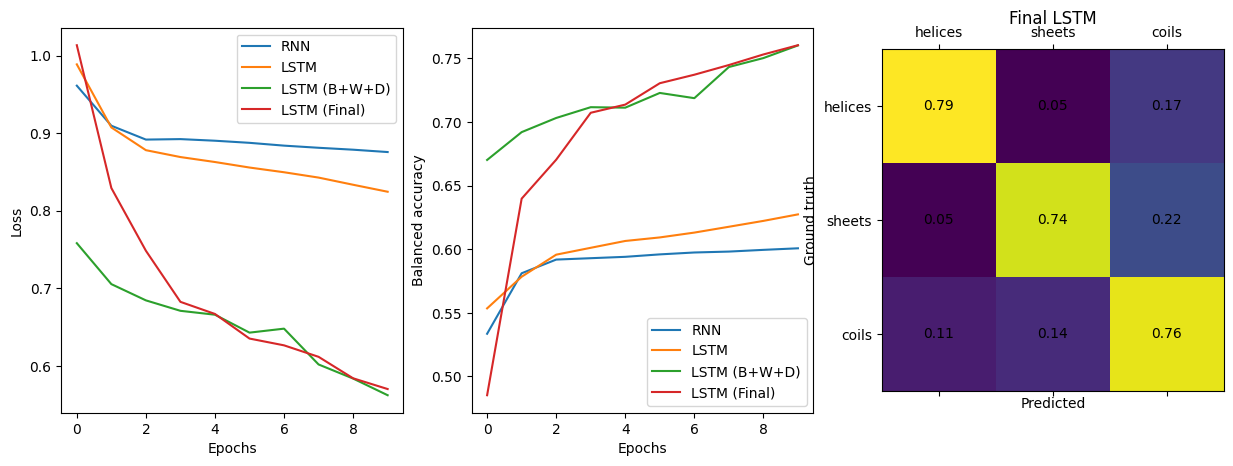

In [26]:
plt.rcParams["figure.figsize"] = (15,5)

# plot test loss curves
"""
INSERT CODE HERE
"""
plt.subplot(1, 3, 1)
plt.plot(loss_rnn[1])
plt.plot(loss_lstms[0][1])
plt.plot(loss_lstms[-1][1])
plt.plot(loss_lstm[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(('RNN', 'LSTM', 'LSTM (B+W+D)', 'LSTM (Final)'))

# plot test balanced accuracy
"""
INSERT CODE HERE
"""
plt.subplot(1, 3, 2)
plt.plot(acc_rnn[1])
plt.plot(acc_lstms[0][1])
plt.plot(acc_lstms[-1][1])
plt.plot(acc_lstm[1])
plt.xlabel('Epochs')
plt.ylabel('Balanced accuracy')
plt.legend(('RNN', 'LSTM', 'LSTM (B+W+D)', 'LSTM (Final)'))

# show the confusion matrix of the best performing model
"""
INSERT CODE HERE
"""
predictions, outputs = evaluate(lstm, dataloader_test)
cm = metrics.confusion_matrix(outputs, predictions, normalize='true')
ax = plt.subplot(1, 3, 3)
ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '%.2f' % z, ha='center', va='center')
ax.set_xticklabels([''] + mappings_hl)
ax.set_yticklabels([''] + mappings_hl)
plt.title('Final LSTM')
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.show()


Looks like we have improved the results to 75%! Convolutional layers seem to be great embedding layers for sequence data. It turns out that you can actually achieve 84% accuracy on this dataset (Torrisi et.al., 2019), by using all available training data (we only used a fraction due to RAM limits), increasing the depth/width of the model, more epochs, etc. Feel free to try this out on your own if you have the resources available! 

Note that your results might differ a little due to the different initialization that you might have used. By fixing the seed in the first code cell and running everything from scratch, the results should be reproducible. 